In [ ]:
import base64
import itertools
import logging
import tempfile
import time
import traceback
import warnings
from pathlib import Path
from typing import Literal, Optional

import pandas as pd
from matplotlib.cm import get_cmap
from matplotlib.colors import to_hex
from tqdm.auto import tqdm

from unpast.misc.ds_synthetic.dataset import (
    build_dataset,
    get_scenario_dataset_blueprint, 
    get_modular_dataset_blueprint, 
)
from unpast.misc.eval.metrics import calc_metrics
from unpast.run_unpast import unpast
from unpast.utils.io import read_bic_table, read_exprs

In [2]:
# Settings

# using several seeds for datasets/method to check for reproducibility
DATASET_SEEDS = range(42, 42 + 5)
UNPAST_SEEDS = range(142, 142 + 5)

DS_BLUEPRINT = get_modular_dataset_blueprint()
# DS_BLUEPRINT = get_scenario_dataset_blueprint(scale=1)
OUTPUT_DIR = Path(tempfile.gettempdir()) / "unpast_debug_calc_metrics"
UNPAST_ARGS = {
    "clust_method": "Louvain",
}

# Build datasets, run UnPaSt, and calculate metrics

In [ ]:
# Generate datasets

datasets = {}
for ds_seed in DATASET_SEEDS:
    show_images = ds_seed == DATASET_SEEDS[0]  # show only once
    ds = build_dataset(
        DS_BLUEPRINT,
        seed_prefix=str(ds_seed),
        output_dir=OUTPUT_DIR / f"ds_{ds_seed}",
        show_images=show_images,
    )
    datasets[ds_seed] = ds

In [4]:
# calculate predictions and metrics

logging.disable(logging.CRITICAL)
warnings.filterwarnings("ignore")

pbar = tqdm(
    total=len(DATASET_SEEDS) * len(UNPAST_SEEDS) * len(datasets[DATASET_SEEDS[0]])
)
results = []
for ds_seed, unpast_seed in itertools.product(DATASET_SEEDS, UNPAST_SEEDS):
    for entry_name, row in datasets[ds_seed].iterrows():
        try:
            pbar.update(1)
            pbar.set_description(
                f"Running UnPaSt: ds_seed={ds_seed} unpast_seed={unpast_seed} name={entry_name} "
            )
            start_time = time.time()

            out_dir = str(OUTPUT_DIR / f"unpast_results/{ds_seed}_{unpast_seed}")
            ds = datasets[ds_seed]
            pred_bics = unpast(
                str(row["exprs_file"]),
                seed=unpast_seed,
                out_dir=out_dir,
                verbose=False,
                **UNPAST_ARGS,
            )

            metrics = calc_metrics(
                true_biclusters=read_bic_table(row["bic_file"]),
                pred_biclusters=pred_bics,
                exprs=read_exprs(row["exprs_file"]),
            )
            metrics["time_sec"] = time.time() - start_time
            metrics["ds_seed"] = ds_seed
            metrics["unpast_seed"] = unpast_seed
            metrics["name"] = entry_name
            results.append(metrics)

        except Exception as e:
            print(
                f"Error for ds_seed={ds_seed} unpast_seed={unpast_seed} type={entry_name}: {e}"
            )
            traceback.print_exc()

pbar.close()
performance_df = pd.DataFrame(results)

  0%|          | 0/1100 [00:00<?, ?it/s]

# Analyze metrics

In [5]:
# prepare some useful styling functions
# 1. function to highlight restults in a+-b string format
# 2. build icons to display in dataframes


def get_style(
    type: Literal["mean", "std"],
    revert: Optional[bool] = None,
    mult: Optional[float] = None,
):
    ind, _revert, _mult = {
        "mean": (0, True, 1.0),
        "std": (-1, False, 5.0),
    }[type]
    revert = revert or _revert
    mult = mult or _mult
    cmap = get_cmap("Reds")

    def style_function(cell_val):
        if "+-" not in cell_val and "±" not in cell_val:
            # some other format, e.g. image
            return ""

        val = float(cell_val.split()[ind])
        if revert:
            val = 1.0 - val
        val *= mult

        bg_color = cmap(val)
        text_color = "black" if val < 0.8 else "white"
        style = f"background-color: {to_hex(bg_color)};color: {text_color}"
        return style

    return style_function


def _show_heatmap_icon(extra_info):
    if "heatmap_icon_path" not in extra_info:
        return ""
    with open(extra_info["heatmap_icon_path"], "rb") as f:
        data = base64.b64encode(f.read()).decode()
    return f'<img src="data:image/png;base64,{data}" width="25" height="25"/>'


icons_ds0 = datasets[DATASET_SEEDS[0]]["extra_info"].apply(_show_heatmap_icon)
# pd.DataFrame(icons_ds0).style.format()

Average ds-entry-performance (mean ± std) across nruns=25.0 (5 dataset seeds and 5 unpast seeds).

(use 'std' or 'mean' in the last cell line to change highliting logic)


,wARIs,F1_f_avg,F1_s_avg,FDR_bic,Recall_bic,AP_ARI,time_sec,icon
name,,,,,,,,
big_mu_1.0,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,1.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,2.19 ± 0.13,
big_mu_2.0,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,1.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,2.28 ± 0.24,
big_mu_3.0,0.97 ± 0.03,0.10 ± 0.02,0.98 ± 0.01,0.16 ± 0.21,0.05 ± 0.01,0.00 ± 0.00,2.27 ± 0.32,
big_mu_5.0,1.00 ± 0.00,0.80 ± 0.24,1.00 ± 0.00,0.27 ± 0.31,0.73 ± 0.32,0.56 ± 0.50,2.29 ± 0.20,
big_mu_7.0,1.00 ± 0.00,1.00 ± 0.00,1.00 ± 0.00,0.02 ± 0.03,1.00 ± 0.00,1.00 ± 0.00,2.17 ± 0.22,
cols_overlap_0,1.00 ± 0.00,0.99 ± 0.02,1.00 ± 0.00,0.00 ± 0.00,0.97 ± 0.04,0.94 ± 0.08,0.48 ± 0.04,
cols_overlap_1,1.00 ± 0.00,0.99 ± 0.01,1.00 ± 0.00,0.00 ± 0.00,0.99 ± 0.03,0.97 ± 0.06,0.54 ± 0.09,
cols_overlap_2,1.00 ± 0.00,0.98 ± 0.02,1.00 ± 0.00,0.01 ± 0.02,0.97 ± 0.05,0.92 ± 0.09,0.60 ± 0.11,
cols_overlap_3,1.00 ± 0.00,1.00 ± 0.01,1.00 ± 0.00,0.01 ± 0.02,1.00 ± 0.00,0.98 ± 0.04,0.49 ± 0.03,

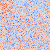
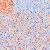
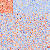
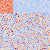
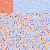
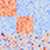
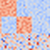
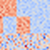
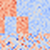
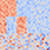
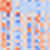
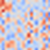
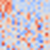
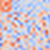
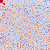
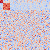
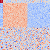
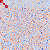
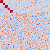
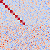
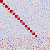
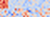
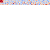
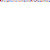
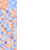
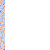
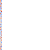
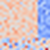
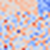
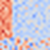
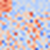
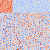
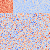
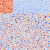
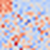
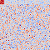
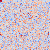
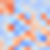
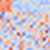
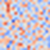
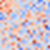
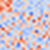
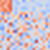
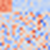

In [6]:
# Calculate mean and std

metrics_to_show = performance_df.drop(columns=["ds_seed", "unpast_seed"]).groupby(
    "name"
)
metrics_df = metrics_to_show.mean()
_std_vals = metrics_to_show.std()
for col in metrics_df.columns:
    metrics_df[col] = metrics_df[col].combine(
        _std_vals[col], lambda m, s: f"{m:.2f} ± {s:.2f}"
    )

num_avg = len(performance_df) / len(metrics_df)
print(
    f"Average ds-entry-performance (mean ± std) across nruns={num_avg}"
    f" ({performance_df['ds_seed'].nunique()} dataset seeds"
    f" and {performance_df['unpast_seed'].nunique()} unpast seeds)."
    "\n\n"
    "(use 'std' or 'mean' in the last cell line to change highliting logic)"
)
metrics_df["icon"] = icons_ds0[metrics_df.index]
metrics_df.style.applymap(get_style("mean"))  # "mean" or "std"

In [7]:
# Compare ds seed stability vs unpast seed stability
avg_on_ds = (
    performance_df.drop(columns=["name"])
    .groupby(["unpast_seed", "ds_seed"])
    .mean()
    .reset_index()
)


def color(val):
    color = "background-color: red" if float(val.split()[-1]) > 0.02 else ""
    return color


for col in ["ds_seed", "unpast_seed"]:
    other = "ds_seed" if col == "unpast_seed" else "unpast_seed"

    num_avg = len(avg_on_ds) / len(avg_on_ds[col].unique())
    print(
        f"Average performance (mean ± std) across nruns={num_avg}"
        f" ({performance_df[other].nunique()} values of {other})"
    )

    ds = avg_on_ds.drop(columns=[other, "time_sec"])
    values = ds.groupby(col).mean()
    std_values = ds.groupby(col).std()
    metrics_df = pd.DataFrame(
        {
            "mean": values.stack(),
            "std": std_values.stack(),
        }
    )
    metrics_df["mean ± std"] = metrics_df.apply(
        lambda row: f"{row['mean']:.2f} ± {row['std']:.3f}", axis=1
    )
    display(
        metrics_df[["mean ± std"]]
        .unstack()
        .copy()
        .style.applymap(get_style("std", mult=20.0))
    )  # highlight by std

Average performance (mean ± std) across nruns=5.0 (5 values of unpast_seed)


Average performance (mean ± std) across nruns=5.0 (5 values of ds_seed)


In [8]:
# Average metrics values averaged across both dataset seeds and unpast seeds
# don't confuse with averaging across dataset entries which have another std value
# `performance_df.drop(columns=['ds_seed', 'unpast_seed', 'name']).std()`
avg_on_ds = (
    performance_df.drop(columns=["name"])
    .groupby(["unpast_seed", "ds_seed"])
    .mean()
    .reset_index()
    .drop(columns=["unpast_seed", "ds_seed"])
)

num_avg = len(avg_on_ds)
print(
    f"Average performance (mean ± std) on across nruns={num_avg}"
    f": {performance_df['ds_seed'].nunique()} dataset seeds"
    f" and {performance_df['unpast_seed'].nunique()} unpast seeds"
)

values = avg_on_ds.mean()
std_values = avg_on_ds.std()
metrics_df = pd.DataFrame(
    {
        "mean": values,
        "std": std_values,
    }
)
metrics_df["mean ± std"] = metrics_df.apply(
    lambda row: f"{row['mean']:.2f} ± {row['std']:.2f}", axis=1
)
display(metrics_df[["mean ± std"]])

# save metrics
metrics_df.to_csv("metrics.tsv", sep="\t")

Average performance (mean ± std) on across nruns=25: 5 dataset seeds and 5 unpast seeds


,mean ± std
wARIs,0.61 ± 0.02
F1_f_avg,0.50 ± 0.02
F1_s_avg,0.60 ± 0.02
FDR_bic,0.40 ± 0.03
Recall_bic,0.46 ± 0.02
AP_ARI,0.32 ± 0.03
time_sec,1.04 ± 0.03
